# Transformer Variational Autoencoder Demonstration
The purpose of this notebook is to demonstrate a simple Variational Autoencoder (VAE) model, trained on SELF-referencIng Embedded Strings (SELFIES).

## Load and prepare the data

Call `bddata.setup` to:
 - Download the QM9 dataset to a location outside of source code control. 
 - Compute the SELFIES from SMILES, discarding records with unusable SMILES strings
 - Calculate QM9 dataset summary statistics
 - Create the vocabulary
 - Pad SELFIES out to the length of the record with the maximal SELFIES tokens
 - Add a start token to facilitate transition probability profile generation

In [1]:
%%time
from importlib import reload

import bd
reload(bd)
from bd import data as bddata
from bd import log as bdl

PAD_TOKEN="<pad>"
START_TOKEN="<start>"


bdl.set_verbosity(bdl.INFO)
dataset_selfies, max_tokens, token_stats, vocab, start_token, pad_token = bddata.setup(data_path='../../data/QM9',
                                                                           start_token=START_TOKEN,
                                                                           pad_token=PAD_TOKEN)


+ Add SELFIES to the dataset entries...
outputting 'x' for each record skipped due to unusable SMILES string.
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [2]:
len(dataset_selfies), max_tokens, token_stats, len(vocab),  start_token, pad_token, dataset_selfies[0]

(129428,
 21,
 {'median': 13.0,
  'average': 13.759194301078592,
  'std': 2.0650592942840698,
  'max': 21,
  'min': 1},
 56,
 '<start>',
 '<pad>',
 Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1], selfies='[C]', encoded_selfies_list=[1]))

## Fit the model

Load the data batches, build the model, fit, and plot the train/validation losses.


In [48]:
%%time
import pytorch_lightning as pl
from pytorch_lightning import Trainer


import bd
import bd.models
reload(bd)
reload(bd.models)
from bd.models import TransformerVAE
from bd.data import SELFIESDataModule, CustomRichProgressBar


EPOCHS = 6
# Model parameters
vocab_size = len(vocab)  # Make sure vocab includes PAD_TOKEN
BATCH_SIZE= 256 #8* vocab_size
EMBEDDING_DIM = max_tokens#21#32
HIDDEN_DIM = 128#64
LATENT_DIM = 64#16
BETA=1.0
USE_MSE=False

# get the data
data_module = SELFIESDataModule(dataset_selfies, 
                                max_selfies_tokens= max_tokens, 
                                start_token_index=vocab[start_token],
                                train_batch_size=BATCH_SIZE,
                                val_batch_size = BATCH_SIZE,
                                drop_last=True,
                                train_val_split=0.8)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()



CPU times: user 9.3 ms, sys: 0 ns, total: 9.3 ms
Wall time: 22 ms


In [49]:
#!pip install einops

In [84]:
import torch
from torch import nn
import pytorch_lightning as pl


model = TransformerVAE(vocab_size=vocab_size, 
                       max_length=21, 
                       d_model=vocab_size, #64, #512,
                       nhead=4,#8
                       num_layers=1, #3, 
                       dim_feedforward=21,#64, #2048, 
                       dropout=0.1)
# Setup the trainer
trainer = pl.Trainer(max_epochs=EPOCHS, callbacks=[CustomRichProgressBar()])  # Adjust according to your setup


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [86]:


# Start training
trainer.fit(model, train_loader, val_loader)



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name         ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder      │ TransformerEncoder │ 15.4 K │
│ 1 │ decoder      │ TransformerDecoder │ 28.3 K │
│ 2 │ embedding    │ Embedding          │  3.1 K │
│ 3 │ to_latent    │ Linear             │  6.4 K │
│ 4 │ from_latent  │ Linear             │  3.2 K │
│ 5 │ output_layer │ Linear             │  3.2 K │
│   │ other params │ n/a                │  1.2 K │
└───┴──────────────┴────────────────────┴────────┘

Trainable params: 60.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 60.8 K                                                                                               
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=6` reached.


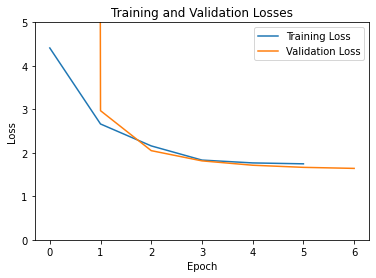

In [87]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(model.train_losses, label='Training Loss')
plt.plot(model.val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,5)
plt.legend()
plt.show()


## Generate a SELFIES

Use the model to generate of a SELFIES string and view the molecular structure.

[=O][CH1+1][\C@H1][Ring2][#C][/N+1][/C@H1][CH1+1][Branch2][CH1+1][=Branch2][CH1+1][/N+1]


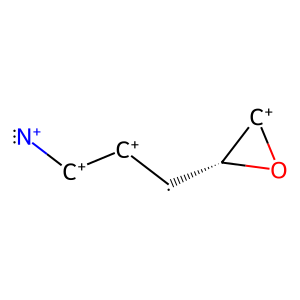

In [114]:
bdl.set_verbosity(bdl.WARN)
gen_max_tokens=13
import bd.assess
reload(bd.assess)
import bd.assess
from bd.assess import generate_and_decode, selfies_to_image
selfies_string, z, generated_indices1 = generate_and_decode(model=model, vocab=vocab, max_tokens=gen_max_tokens, 
                                                                start_token=start_token, 
                                                                pad_token=pad_token, 
                                                                z=None,
                                                                latent_dim = model.d_model)
print(selfies_string)
display(selfies_to_image(selfies_string))